# Analýza dat ze Strava API

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the csv file into a pandas DataFrame
df = pd.read_csv('activities.csv')

df.head(5)

,start_date,distance [km],average_speed [km/h],max_speed [km/h],moving_time [min],total_elevation_gain [m],type,gear_id,kilojoules
0,2024-03-24T08:44:56Z,25.9063,3.6288,36.1368,428.55,20.3,Ride,b10386566,2869.9
1,2024-03-22T12:14:29Z,13.7746,14.7996,67.2588,55.85,182.4,Ride,b10386566,374.0
2,2024-03-21T09:24:07Z,24.1348,12.0096,39.3120,120.58,437.4,Ride,b10386566,840.8
3,2024-03-17T09:31:57Z,41.1926,16.6608,46.3896,148.35,403.5,Ride,b10386566,1105.5
4,2024-03-15T15:46:25Z,23.4629,17.2440,49.1040,81.63,274.5,Ride,b10386566,638.3


## Čištění dat

In [173]:
# Check if there are any 'NaN' values in 'gear_id' column
if df['gear_id'].isnull().any():
    # If 'NaN' values are present, replace them with 'Not available'
    df['gear_id'] = df['gear_id'].fillna('Not available')

# Keep previous replacements rules
df['gear_id'] = df['gear_id'].replace({
    'b10386566': 'Van Rysel', 
    'b7982751': 'Btwin Rockrider 560',
    'b7982758': 'Triban RC520'
})

# The 'replace' function is used to replace "BackcountrySki" values with "NordicSki"
df['type'] = df['type'].replace('BackcountrySki', 'NordicSki')

# Apply the clip function to the 'max_speed [km/h]' column
df['max_speed [km/h]'] = df['max_speed [km/h]'].clip(upper=60)

# Set rows in df dataframe, where avg_speed > 12 or distance > 30 to type "Ride"
df.loc[(df['average_speed [km/h]'] > 12) | (df['distance [km]'] > 30), 'type'] = 'Ride'

# Convert the 'start_date' column into a DateTime format
df['start_date'] = pd.to_datetime(df['start_date'])

# Create new column 'year' from the 'start_date' column
df['year'] = df['start_date'].dt.year

# Transform 'moving_time' to hours
df['moving_time [min]'] = df['moving_time [min]'] / 60

# It would be accurate to rename the column to 'moving_time [hour]'
df.rename(columns={'moving_time [min]': 'moving_time [hour]'}, inplace=True)

# Apply the clip function to the 'moving_time' column
df['moving_time [hour]'] = df['moving_time [hour]'].clip(upper=12)

# Apply the clip function to the 'kilojoules' column
df['kilojoules'] = df['kilojoules'].clip(upper=3000)

# Extract day and month from 'start_date'
df['day'] = df['start_date'].dt.day
df['month'] = df['start_date'].dt.month

# Create a DataFrame that consists only of type 'Ride'
df_ride = df[df['type'] == 'Ride']

## Analýza

In [174]:
# Grouping the dataframe by 'type' and calculating sum of 'distance [km]' for each group
df_grouped_type = df.groupby('type')['distance [km]'].sum()
df_grouped_type = df_grouped_type.reset_index()

df_grouped_type

,type,distance [km]
0,NordicSki,376.1666
1,Ride,13125.2832
2,Run,88.9527
3,Walk,144.4292


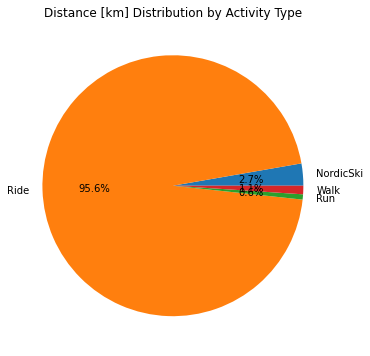

In [175]:
# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(df_grouped_type['distance [km]'], labels=df_grouped_type['type'], autopct='%1.1f%%')
plt.title('Distance [km] Distribution by Activity Type')
plt.show()

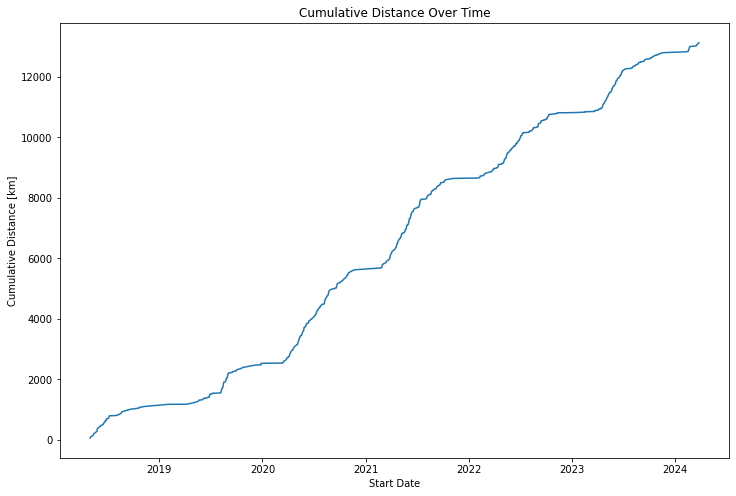

In [176]:
# Sort df_ride by 'start_date'
df_ride = df_ride.sort_values('start_date')

# Create new column 'distance_sum'
df_ride['distance_sum'] = df_ride['distance [km]'].cumsum()

# Lineplot for df_ride using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='start_date', y='distance_sum', data=df_ride)
plt.title('Cumulative Distance Over Time')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Distance [km]')
plt.show()

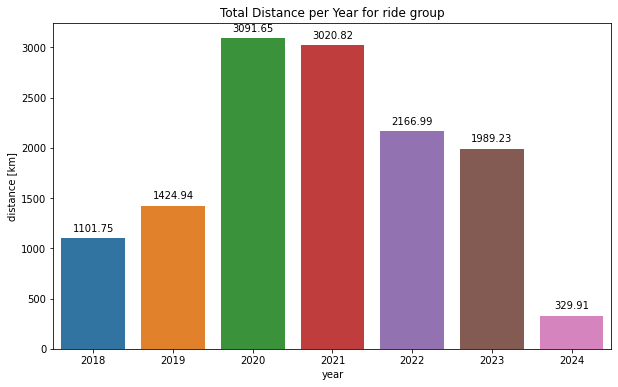

In [177]:
# Grouping the dataframe by 'year' and calculating sum of 'distance [km]' for each group
df_grouped = df_ride.groupby('year')['distance [km]'].sum()

df_grouped = df_grouped.reset_index()

plt.figure(figsize=(10,6))
barplot3 = sns.barplot(x='year', y='distance [km]', data=df_grouped)
plt.title('Total Distance per Year for ride group')

for p in barplot3.patches:
    barplot3.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center',
                     va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')
    


plt.show()

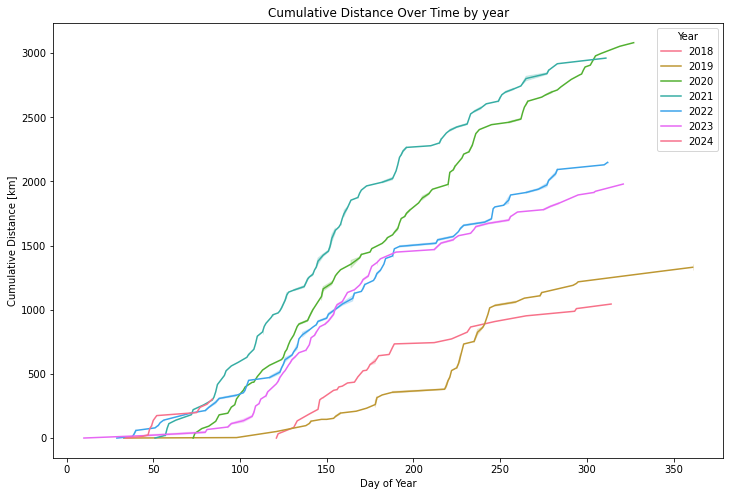

In [178]:
df_ride['day_of_year'] = df_ride['start_date'].dt.dayofyear

for year in df_ride['year'].unique():
    min_distance = df_ride.loc[df_ride['year'] == year, 'distance_sum'].min()
    df_ride.loc[df_ride['year'] == year, 'distance_sum'] -= min_distance

# Create the lineplot
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_ride, x='day_of_year', y='distance_sum', hue='year', palette='husl')
plt.title('Cumulative Distance Over Time by year')
plt.xlabel('Day of Year')
plt.ylabel('Cumulative Distance [km]')
plt.legend(title='Year')
plt.show()

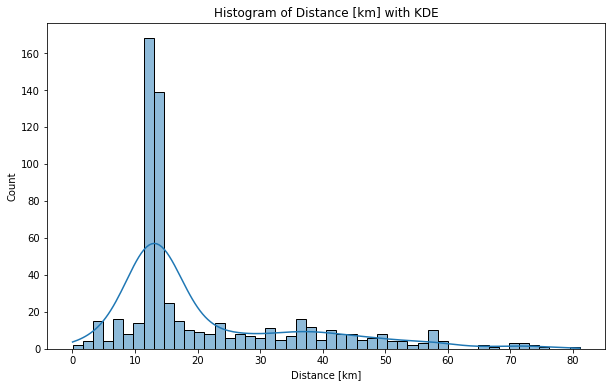

In [179]:
# Create a seaborn histplot with kde
plt.figure(figsize=(10,6))
sns.histplot(df_ride['distance [km]'], kde=True, bins=50)
plt.title('Histogram of Distance [km] with KDE')
plt.xlabel('Distance [km]')
plt.ylabel('Count')
plt.show()

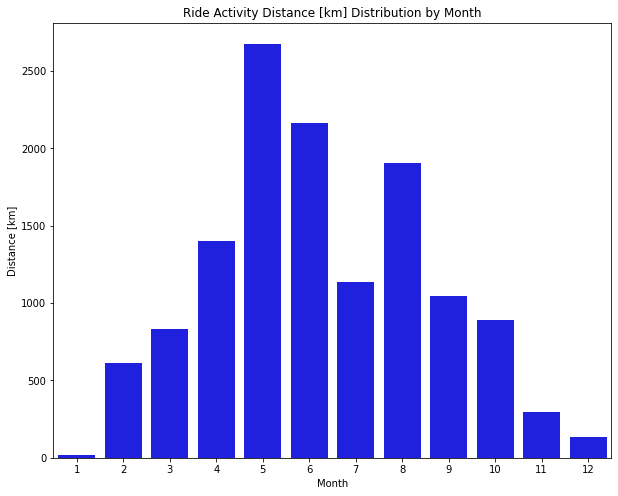

In [180]:
# Group by 'month' and calculate the sum of 'distance [km]'
df_ride_grouped = df_ride.groupby('month')['distance [km]'].sum()

# Reset index to convert into DataFrame
df_ride_grouped = df_ride_grouped.reset_index()

# Bar plot for df_ride_grouped using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='month', y='distance [km]', data=df_ride_grouped, color='blue')
plt.title('Ride Activity Distance [km] Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Distance [km]')
plt.show()

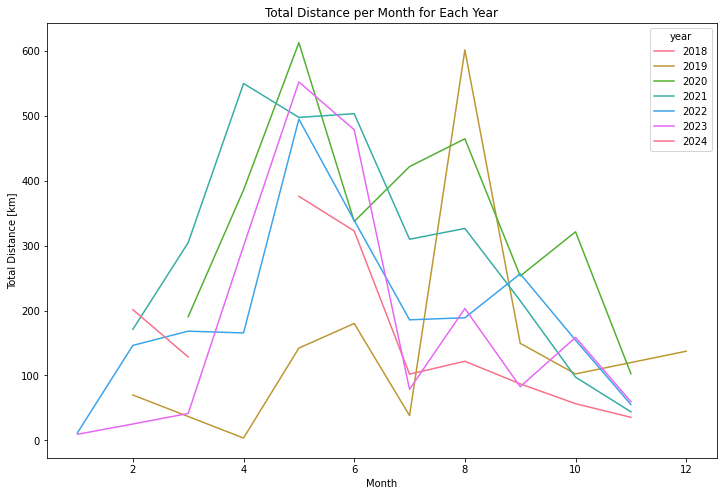

In [181]:
# Grouping the dataframe by 'year' and 'month' and calculating sum of 'distance [km]' for each group
df_grouped_month = df_ride.groupby(['year', 'month'])['distance [km]'].sum()

# Reset index to convert into DataFrame
df_grouped_month = df_grouped_month.reset_index()

# reshape dataframe
df_reshaped = df_grouped_month.pivot(index='month', columns='year', values='distance [km]').reset_index()

# melt dataframe to a long format for seaborn
df_melted = pd.melt(df_reshaped, id_vars='month', value_vars=df_reshaped.columns[1:], var_name='year', value_name='distance [km]')

plt.figure(figsize=(12,8))
sns.lineplot(data = df_melted, x = "month", y = "distance [km]", hue="year", palette="husl")
plt.title('Total Distance per Month for Each Year')
plt.xlabel('Month')
plt.ylabel('Total Distance [km]')
plt.show()

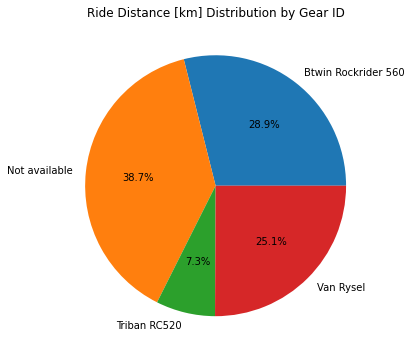

In [182]:
# Group 'df' by 'gear_id' where type is 'Ride' and calculate sum of 'distance [km]' for each group
df_ride_by_gear = df[df['type'] == 'Ride'].groupby('gear_id')['distance [km]'].sum()
df_ride_by_gear = df_ride_by_gear.reset_index()

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(df_ride_by_gear['distance [km]'], labels=df_ride_by_gear['gear_id'], autopct='%1.1f%%')
plt.title('Ride Distance [km] Distribution by Gear ID')
plt.show()

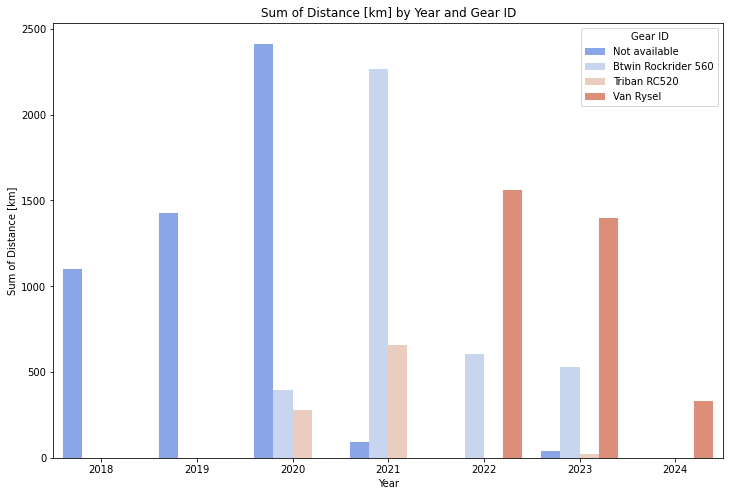

In [183]:
# Group df_ride by 'year' and 'gear_id' and calculate sum of 'distance [km]' for each group
df_ride_grouped_gear = df_ride.groupby(['year', 'gear_id'])['distance [km]'].sum().reset_index()

# Use seaborn to create a bar plot with 'year' as x-axis, 'distance [km]' as y-axis and 'gear_id' as hue
plt.figure(figsize=(12, 8))
sns.barplot(x='year', y='distance [km]', hue='gear_id', data=df_ride_grouped_gear, palette='coolwarm')
plt.title('Sum of Distance [km] by Year and Gear ID')
plt.xlabel('Year')
plt.ylabel('Sum of Distance [km]')
plt.legend(title='Gear ID')
plt.show()

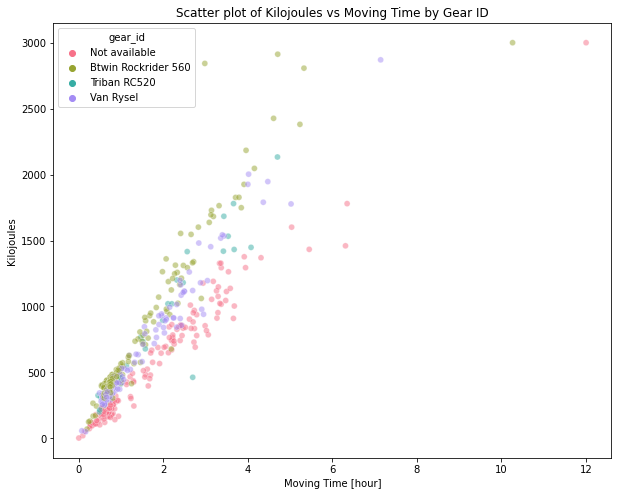

In [184]:
# Scatterplot for df_ride using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='moving_time [hour]', y='kilojoules', hue='gear_id', data=df_ride, palette='husl', alpha=0.5)
plt.title('Scatter plot of Kilojoules vs Moving Time by Gear ID')
plt.xlabel('Moving Time [hour]')
plt.ylabel('Kilojoules')
plt.show()

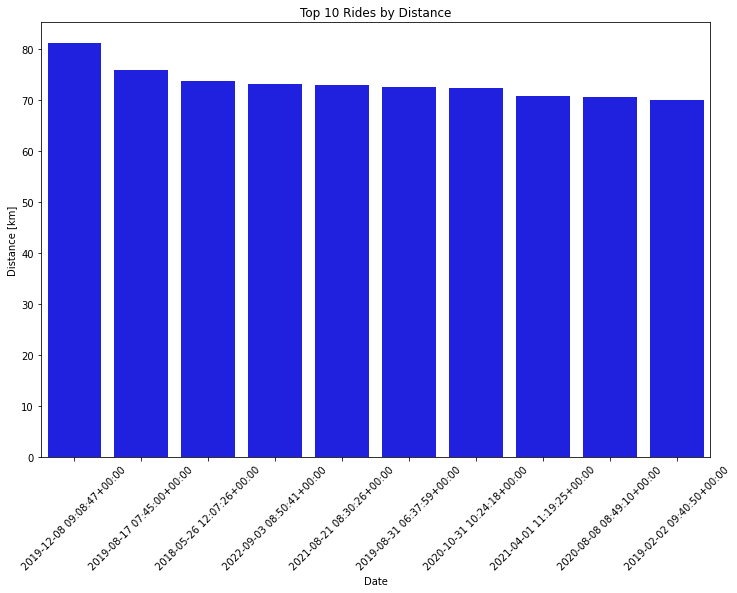

In [185]:
df_ride_sorted = df[df['type'] == 'Ride'].sort_values('distance [km]', ascending=False)

# Sort df_ride_sorted DataFrame by distance in descending order and set 'start_date' as index
df_ride_sorted_top10 = df_ride_sorted.sort_values('distance [km]', ascending=False).set_index('start_date').head(10)

# Draw the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=df_ride_sorted_top10.index, y='distance [km]', data=df_ride_sorted_top10, color='blue')
plt.title('Top 10 Rides by Distance')
plt.xlabel('Date')
plt.ylabel('Distance [km]')
plt.xticks(rotation=45)
plt.show()

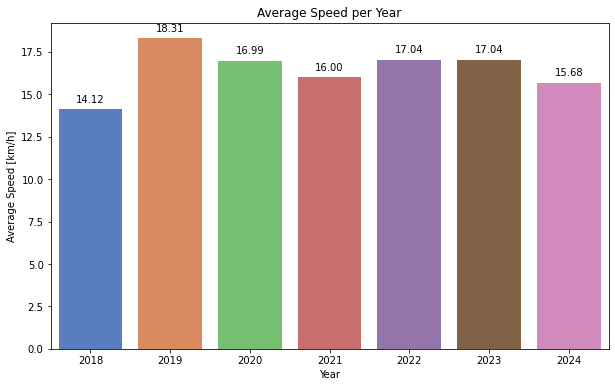

In [186]:
# Calculate average speed per year
df_ride_avg_speed = df_ride.groupby('year')['average_speed [km/h]'].mean().reset_index()

# Bar chart using seaborn
plt.figure(figsize=(10,6))
barplot = sns.barplot(x='year', y='average_speed [km/h]', data=df_ride_avg_speed, palette='muted')
plt.title('Average Speed per Year')
plt.xlabel('Year')
plt.ylabel('Average Speed [km/h]')

# Adding values for each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center',
                     va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')
    
    
plt.show()

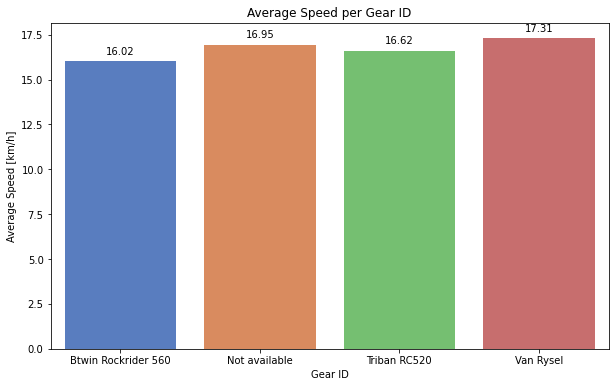

In [187]:
# Calculate average speed per gear_id
df_ride_avg_speed = df_ride.groupby('gear_id')['average_speed [km/h]'].mean().reset_index()

# Bar chart using seaborn
plt.figure(figsize=(10,6))
barplot2 = sns.barplot(x='gear_id', y='average_speed [km/h]', data=df_ride_avg_speed, palette='muted')
plt.title('Average Speed per Gear ID')
plt.xlabel('Gear ID')
plt.ylabel('Average Speed [km/h]')

for p in barplot2.patches:
    barplot2.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center',
                     va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')
    
plt.show()